# ECG Signal Denoising Demonstration

This notebook provides an interactive demonstration of ECG signal restoration using trained Deep Learning models.

In [ ]:
!pip install wfdb
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

try:
    from huggingface_hub import hf_hub_download
    hf_available = True
except Exception:
    hf_available = False
    print("huggingface_hub is not installed. Run: pip install huggingface_hub")

In [2]:
try:
    from google.colab import drive
    root = '/content/drive/'
    drive.mount(root)
    path_proj = 'MyDrive/Colab Notebooks/denoise-ecg'
    colab_mode = True
except ImportError:
    root = '../'
    path_proj = ''
    colab_mode = False
    print("Local environment detected.")

if colab_mode:
    sys.path.append(os.path.join(root, path_proj))
else:
    sys.path.append(root)

from models.autoencoder import ECGAutoencoder
from models.diffusion import DiffusionModel, ECGDiffusion
from utils.data_utils import ECGDenoisingDataset

if colab_mode:
    # Corrected escaping for JSON: use single backslash in Python string, json.dump will escape it to double.
    %cd /content/drive/MyDrive/Colab\ Notebooks/denoise-ecg

print("Environment initialized.")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/denoise-ecg
Environment initialized.


### 1. Signal Generation

We generate a synthetic 12-lead ECG signal and inject realistic noise.

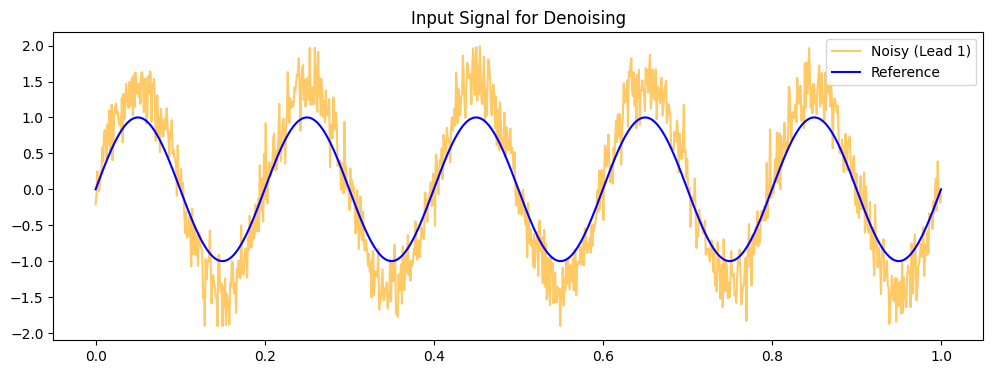

In [3]:
seq_len = 1000
t = np.linspace(0, 1, seq_len)
clean_signal_np = np.array([np.sin(2 * np.pi * (5 + i/2) * t) for i in range(12)])

dummy_dataset = ECGDenoisingDataset(clean_signal_np.T[np.newaxis, :, :])
clean_signal_tensor = dummy_dataset.data[0]
noisy_signal_tensor, _ = dummy_dataset[0]

plt.figure(figsize=(12, 4))
plt.plot(t, noisy_signal_tensor[0].cpu().numpy(), label='Noisy (Lead 1)', color='orange', alpha=0.6)
plt.plot(t, clean_signal_tensor[0].cpu().numpy(), label='Reference', color='blue')
plt.legend()
plt.title("Input Signal for Denoising")
plt.show()

### 2. Model Inference

In [ ]:
model_choice = "diffusion"  # Options: "autoencoder", "diffusion"
weight_source = "local"  # Options: "local", "huggingface"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = noisy_signal_tensor.unsqueeze(0).to(device)

hf_repos = {
    "autoencoder": "mahamat9/ecgunetdenoiser",
    "diffusion": "",  # if you uploaded diffusion weights
}
hf_filenames = {
    "autoencoder": "best_autoencoder.pth",
    "diffusion": "best_diffusion.pth",
}

In [ ]:
def get_weights_path(model_key: str) -> str:
    if weight_source == "huggingface":
        if not hf_available:
            raise RuntimeError("huggingface_hub is not available. Install it first.")
        repo_id = hf_repos.get(model_key, "")
        filename = hf_filenames.get(model_key, "")
        if not repo_id:
            raise RuntimeError(f"No Hugging Face repo set for '{model_key}'.")
        return hf_hub_download(repo_id=repo_id, filename=filename)
    return f"../models/{hf_filenames[model_key]}"

if model_choice == "autoencoder":
    model = ECGAutoencoder(input_channels=12).to(device)
    weights = get_weights_path("autoencoder")
    if os.path.exists(weights):
        model.load_state_dict(torch.load(weights, map_location=device))
    model.eval()
    with torch.no_grad():
        denoised = model(input_tensor).cpu().squeeze()
else:
    model = DiffusionModel(input_channels=12).to(device)
    weights = get_weights_path("diffusion")
    if os.path.exists(weights):
        model.load_state_dict(torch.load(weights, map_location=device))
    handler = ECGDiffusion(model)
    denoised = handler.denoise(input_tensor).cpu().squeeze()

print(f"Denoising with {model_choice} complete.")

Denoising with diffusion complete.


### 3. Results Visualization

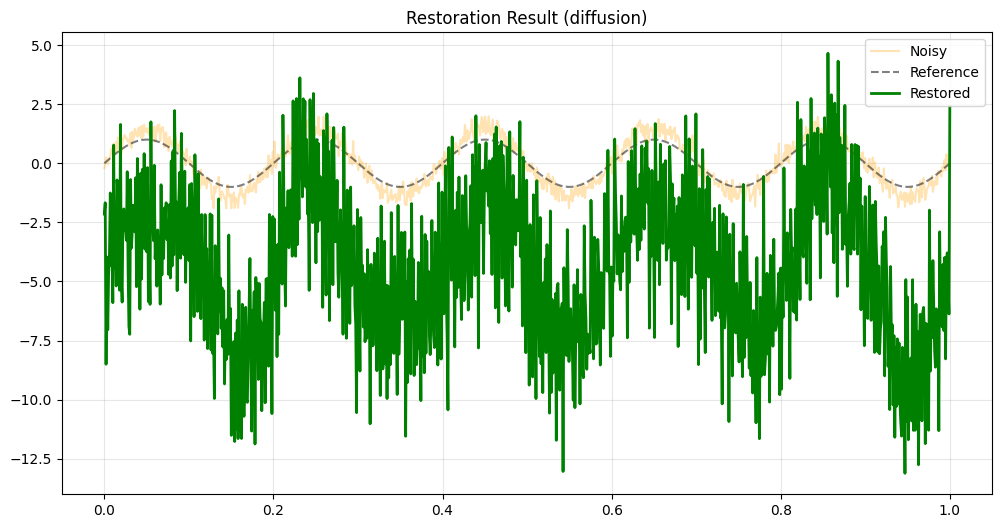

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal_tensor[0].cpu().numpy(), label='Noisy', color='orange', alpha=0.3)
plt.plot(t, clean_signal_tensor[0].cpu().numpy(), 'k--', label='Reference', alpha=0.5)
plt.plot(t, denoised[0].cpu().numpy(), label='Restored', color='green', linewidth=2)
plt.legend()
plt.title(f"Restoration Result ({model_choice})")
plt.grid(True, alpha=0.3)
plt.show()